In [1]:
# -*- coding: utf-8 -*-
"""
Created on May 20, 2024
Last modified on May 23, 2024
@Author: Guan-Fu Liu

Test the interpolate_yield_Z function

"""
import numpy as np
import pandas as pd
import sys
sys.path.insert(0, '/Users/liuguanfu/Workspace/SAS-21/targets/MRK1216/spex/jupyter/IMF')
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy import interpolate
import h5py
from tqdm import tqdm
import datetime
import re
# The following are the modules defined in the same directory
from MassLifetime import MassLifetime
from IMF import IMF
from SupernovaeIa import SNIa
import primordial_gas as pg
import constants
%matplotlib widget

In [2]:
###### Set the input and output directories and essential parameters ######
input_dir = "./inputs/"
output_dir = "./outputs/"
SFE = 0.3 # Star formation efficiency
# 0.1 is a typical value, 0.3 is an enhanced value, larger than 0.5 is not physical
if SFE > 0.5:
    print("The star formation efficiency is too high, please check the input value.")
    print("The typical value is 0.1, the enhanced value is 0.3.")
    print("EXIT!")
    sys.exit()

IMF = IMF(IMF_type='Salpeter')
SNIa = SNIa(IMF.imf)
SNIaOn = True  # Whether to consider the SNIa
###### Set the input and output directories and essential parameters ######

###### Load the star formation history ######
SFH = { }
# SFH['File'] = f"{input_dir}/SFH-1delta.txt"
# SFH['Age'] = np.loadtxt(SFH['File'])[:, 0]
# SFH['SFR'] = np.loadtxt(SFH['File'])[:, 1]

SFH['File'] = f"{input_dir}/SFH.h5"
with h5py.File(SFH['File'], 'r') as f:
    SFH['Age'] = f['SFH/1Square'][...][:, 0]
    SFH['SFR'] = f['SFH/1Square'][...][:, 1]

SFH['Mstar'] = np.zeros(len(SFH['Age']))
SFH['TimeBin'] = np.zeros(len(SFH['Age']))
SFH['TimeBin'][:-1] = np.diff(SFH['Age'])  # The time bin of each time, the time bin of the last time is set to ZERO.
SFH['Mstar'][:-1] = SFH['SFR'][:-1] * np.diff(SFH['Age'])  # The mass of stars formed in each time bin
# We do not consider the mass of stars formed in the last time!
SFH['Mtot'] = np.sum(SFH['Mstar'])  # The total mass of stars formed.
if np.diff(SFH['Age'])[0] < 0:
    print("The age should be in ascending order!")
    print("EXIT!")
    sys.exit()
###### Load the star formation history ######

###### Load the yields table ######
yield_files = {"AGB+SNcc": "./inputs/NuPyCEE/portinari98_gce_in_igimf/yields1.h5",
                "SNIa": "./inputs/SNIa_TNH93/yields1.h5"}
files = {key: h5py.File(value, 'r') for key, value in yield_files.items()}
groups = {key: list(files[key].keys()) for key in files.keys()}  # The available metallicity values in yield table
# The available metallicity values in yield table
Zyield = {key: np.array([float(group.split("=")[1]) for group in groups[key]]) for key in groups.keys()}
# Sort the metallicity values in ascending order
groups = {key: [groups[key][a] for a in Zyield[key].argsort()] for key in groups.keys()}
# Sort the Zyield in ascending order
Zyield = {key: Zyield[key][Zyield[key].argsort()] for key in Zyield.keys()}

ElemNotice = ["H", "He", "C", "N", "O", "Ca", "Ne", "Si", "Mg", "S", "Fe", "Other"] # The elements we are interested in
# They should appear in the yield table from AGB+SNcc.
# It should contain H, He and Other.
# The finally selected elements are the intersection of ElemNotice and the elements avaliable in the yield table.
# You may as well not to notice too many elements, which will speed down the calculation.
dfs = { }
ElemIntersect = { }
for key in files.keys():
    dfs[key] = { }
    ElemIntersect[key] = { }
    for group in groups[key]:
        if key == "SNIa":
            dfs[key][group] = pd.DataFrame(files[key][group]['Original'][...])
        else:
            dfs[key][group] = pd.DataFrame(files[key][group]['Interpolated'][...])
        dfs[key][group].loc[:, 'M'] = dfs[key][group].loc[:, 'M'].astype(str)
        dfs[key][group].set_index('M', inplace=True)
        index = dfs[key][group].index
        index = [False if a in ElemNotice + ['Mrem'] else True for a in index]
        # Add the mass of the elements not in ElemNotice to the "Other" element
        if "Other" in dfs[key][group].index:
            dfs[key][group].loc["Other"] += dfs[key][group].loc[index].sum(axis=0)
        else:
            dfs[key][group].loc["Other"] = dfs[key][group].loc[index].sum(axis=0)
        ElemIntersect[key][group] = list(set(ElemNotice).intersection(set(dfs[key][group].index)))

for key in files.keys():
    for group in groups[key]:
        if len(set(ElemNotice)-set(ElemIntersect[key][group]))>0:
            print("The elements you notice but not available in the yield table of %s, %s are" %\
                 (key, group), set(ElemNotice)-set(ElemIntersect[key][group]))

###### Load the yields table ######

The elements you notice but not available in the yield table of SNIa, Z=0.02 are {'C', 'He', 'H', 'N', 'Ca'}


In [3]:
from scipy import interpolate
class InterpolateYields:
    """
    Define the class of interpolating the yields.
    For AGB and SNcc, the yield of the element i is denoted as Y_{i}(Z, m).
    Y_{i}(Z, m) is the yield of the element i for a star with mass m and metallicty Z.
    The yield table only gives a few values of Z and m, and hence some interpolation is needed.
    For a given metallicity Z and a given element, we interpolate the yield of the element with respect to the mass of the star.
    For a given element and mass, we interpolate the yield with respect to the metallicity, which could be serval methods 
    (for details, see below).
    For SNIa, the yield of the element i is denoted as Y_{i}(Z).
    Therefore, the interpolation is only conducted with respect to the metallicity.
    The interpolation with respect to the mass is linear interpolation.
    """
    def __init__(self, dfs, kind='linear'):
        """
        Initialize the class that enables the interpolation of the yields.

        Parameters
        ----------
        dfs : dict
            The dictionary containing the yield tables.
            Its keys are dict_keys(['AGB+SNcc', 'SNIa']), and the values are something like:
            dfs['AGB+SNcc']: dict_keys(['Z=0.0001', 'Z=0.0003', 'Z=0.001', 'Z=0.02', 'Z=0.05']), and
            dfs['SNIa']: dict_keys(['Z=0.0002', 'Z=0.002', 'Z=0.01', 'Z=0.02'])).
            The value of the metallicities may vary according to the yield table.
            dfs['AGB+SNcc']['Z=0.0001'] is a DataFrame
        kind : str
            The kind of interpolation. It should be in ['linear-linear', 'linear-log', 'log-linear', 'log-log', 'nearest', 'TNG-like'].
            The default is 'linear-linear'.
            For linear-linear interpolation:
                Y = Y_low + (Y_high - Y_low)/(Z_high - Z_low)*(ZGas - Z_low)
                Y and Z are linearly interpolated.
            For linear-log interpolation:
                Y = Y_low + (Y_high - Y_low)/(log(Z_high) - log(Z_low))*(log(ZGas) - log(Z_low))
                Y and log Z are linearly interpolated.
                In case of Z_low is zero, we set Z_low = 1e-10.
                This is the same as what is done in TNG simulation.
            For log-linear interpolation:
                log Y = log Y_low + (log Y_high - log Y_low)/(Z_high - Z_low)*(ZGas - Z_low)
                Y = 10**(log10(Y_low) + (log10(Y_high) - log10(Y_low))/(Z_high - Z_low)*(ZGas - Z_low))
                log Y and Z are linearly interpolated.
                In case of Y_low or Y_high is zero, we re-write the above equation as:
                Y = Y_low ** ((Z_high-ZGas)/(Z_high-Z_low)) * Y_high ** ((ZGas-Z_low)/(Z_high-Z_low))
            For log-log interpolation:
                log Y = log Y_low + (log Y_high - log Y_low)/(log Z_high - log Z_low)*(log ZGas - log Z_low)
                Y = 10**(log10(Y_low) + (log10(Y_high) - log10(Y_low))/(log(Z_high) - log(Z_low))*(log(ZGas) - log(Z_low))
                In case of Y_low or Y_high is zero, we re-write the above equation as:
                Y = Y_low ** ((log(Z_high)-log(ZGas))/(log(Z_high)-log(Z_low))) * 
                    Y_high ** ((log(ZGas)-log(Z_low))/(log(Z_high)-log(Z_low)))
                In case of Z_low is zero, we set Z_low = 1e-10.
            For nearest interpolation:
                Y = Y_nearest
            For TNG-like interpolation:
                The interpolation is the same as the linear-log interpolation.

            If ZGas is less than the lowest metallicity in the yield table, the lowest metallicity is used.
            If ZGas is larger than the highest metallicity in the yield table, the highest metallicity is used.

            If there is only one metallicity in the yield table (as is often the case for SNIa), the interpolation is not needed
            We will use the nearest interpolation.
        """
        self.dfs = dfs
        groups = {key: list(dfs[key].keys()) for key in dfs.keys()}
        # groups is a dictionary like:
        # {'AGB+SNcc': ['Z=0.0001', 'Z=0.0003', 'Z=0.001', 'Z=0.002',],
        #  'SNIa': ['Z=0.0002', 'Z=0.002', 'Z=0.01', 'Z=0.02']}
        Zyield = {key: np.array([float(group.split("=")[1]) for group in groups[key]]) for key in groups.keys()}
        # Zyield is a dictionary like:
        # {'AGB+SNcc': array([0.0001, 0.0003, 0.001 , 0.002 ]),
        #  'SNIa': array([0.0002, 0.002 , 0.01  , 0.02  ])}
        # Sort the metallicity values in ascending order
        self.groups = {key: [groups[key][a] for a in Zyield[key].argsort()] for key in groups.keys()}
        # The available metallicity values in yield table
        self.Zyield = {key: Zyield[key][Zyield[key].argsort()] for key in Zyield.keys()}
        self.kind = kind
        self.Zindex = { }
        self.Zindex['SNIa'] = { }
        self.Zindex['AGB+SNcc'] = { }
        self.interps = { }

        if len(self.Zyield['SNIa']) == 1:
            self.interps['SNIa'] = lambda elem: dfs['SNIa'][self.groups['SNIa'][0]].loc[elem].to_numpy().astype(np.float64)
        else:
            if kind == 'nearest':
                self.interps['SNIa'] = lambda ZGas, elem: self._interp_Z_SNIa_nearest(ZGas, elem)
            elif kind == 'linear-linear':
                self.interps['SNIa'] = lambda ZGas, elem: self._interp_Z_SNIa_linear_linear(ZGas, elem)
            elif kind == 'linear-log':
                self.interps['SNIa'] = lambda ZGas, elem: self._interp_Z_SNIa_linear_log(ZGas, elem)
            elif kind == 'log-linear':
                self.interps['SNIa'] = lambda ZGas, elem: self._interp_Z_SNIa_log_linear(ZGas, elem)
            elif kind == 'log-log':
                self.interps['SNIa'] = lambda ZGas, elem: self._interp_Z_SNIa_log_log(ZGas, elem)
            else:
                print("The kind should be in ['linear-linear', 'linear-log', 'log-linear', 'log-log', 'nearest]")
                print("Return None!")
                self.interps['SNIa'] = None
        if len(self.Zyield['AGB+SNcc']) == 1:
            self.interps['AGB+SNcc'] = lambda elem: self.interpolate_m(0, elem)
            print("There is only one metallicity in the yield table of AGB+SNcc!")
            print("Please check your yield tables!")
        else:
            if kind == 'nearest':
                self.interps['AGB+SNcc'] = lambda ZGas, elem: self._interp_Z_AGB_SNcc_nearest(ZGas, elem)
            elif kind == 'linear-linear':
                self.interps['AGB+SNcc'] = lambda ZGas, elem: self._interp_Z_AGB_SNcc_linear_linear(ZGas, elem)
            elif kind == 'linear-log':
                self.interps['AGB+SNcc'] = lambda ZGas, elem: self._interp_Z_AGB_SNcc_linear_log(ZGas, elem)
            elif kind == 'log-linear':
                self.interps['AGB+SNcc'] = lambda ZGas, elem: self._interp_Z_AGB_SNcc_log_linear(ZGas, elem)
            elif kind == 'log-log':
                self.interps['AGB+SNcc'] = lambda ZGas, elem: self._interp_Z_AGB_SNcc_log_log(ZGas, elem)
            else:
                print("The kind should be in ['linear-linear', 'linear-log', 'log-linear', 'log-log', 'nearest]")
                print("Return None!")
                self.interps['AGB+SNcc'] = None


    def interpolate_m(self, Zi, elem):
        """
        Interpolate the yield of the element with respect to the mass of the star.
        It means that one yield table is selected and the interpolation is done with respect to the mass.

        Parameters
        ----------
        Zi : int
            The index of the metallicity value in the yield table.
        elem : str
            The element name.
        """
        dfs = self.dfs
        groups = self.groups
        m = dfs['AGB+SNcc'][groups['AGB+SNcc'][Zi]].columns.to_numpy().astype(float)
        y = dfs['AGB+SNcc'][groups['AGB+SNcc'][Zi]].loc[elem].to_numpy()
        return interpolate.interp1d(m, y, kind='linear', fill_value='extrapolate')


####### How interpolate the yields of SNIa with respect to Z     ######


    def _interp_Z_SNIa_linear_linear(self, ZGas, elem):
        """
        Interpolate the yield of the element from SNIa with respect to the metallicity.
        The interpolation is done with the linear-linear method.

        Parameters
        ----------
        elem : str
            The element name.
        ZGas : float
            The metallicity of the gas.
        """
        dfs = self.dfs
        Zindex = {}
        Zindex['SNIa'] = { }
        Zyield = self.Zyield
        if ZGas <= Zyield['SNIa'].min():
            Zindex['SNIa']['low'] = Zyield['SNIa'].argmin()
            Zindex['SNIa']['high'] = Zindex['SNIa']['low']
        elif ZGas >= Zyield['SNIa'].max():
            Zindex['SNIa']['high'] = Zyield['SNIa'].argmax()
            Zindex['SNIa']['low'] = Zindex['SNIa']['high']
        else:
            Zindex['SNIa']['high'] = np.where(Zyield['SNIa']==Zyield['SNIa'][Zyield['SNIa']>ZGas].min(),)[0][0]
            Zindex['SNIa']['low']  = np.where(Zyield['SNIa']==Zyield['SNIa'][Zyield['SNIa']<ZGas].max(),)[0][0]
        Z_low = Zyield['SNIa'][Zindex['SNIa']['low']]
        Z_high = Zyield['SNIa'][Zindex['SNIa']['high']]
        # In case of Z_low is zero, we set Z_low = 1e-10.
        Z_low = np.maximum(Z_low, 1e-10)
        # In case of Z_high is zero, we set Z_high = 1e-10.
        Z_high = np.maximum(Z_high, 1e-10)
        self.Zindex['SNIa'] = Zindex['SNIa']
        if Z_low == Z_high:
            return dfs['SNIa'][groups['SNIa'][Zindex['SNIa']['low']]].loc[elem, groups['SNIa'][Zindex['SNIa']['low']]]
        else:
            Y_low = dfs['SNIa'][groups['SNIa'][Zindex['SNIa']['low']]].loc[elem, groups['SNIa'][Zindex['SNIa']['low']]]
            Y_high = dfs['SNIa'][groups['SNIa'][Zindex['SNIa']['high']]].loc[elem, groups['SNIa'][Zindex['SNIa']['high']]]
            Y = Y_low + (Y_high-Y_low)/(Z_high-Z_low)*(ZGas-Z_low)
            return Y
        # SNIa, linear-linear interpolation

    
    def _interp_Z_SNIa_linear_log(self, ZGas, elem):
        """
        Interpolate the yield of the element from SNIa with respect to the metallicity.
        The interpolation is done with the linear-log method.

        Parameters
        ----------
        elem : str
            The element name.
        ZGas : float
            The metallicity of the gas.
        """
        dfs = self.dfs
        Zindex = {}
        Zindex['SNIa'] = { }
        Zyield = self.Zyield
        if ZGas <= Zyield['SNIa'].min():
            Zindex['SNIa']['low'] = Zyield['SNIa'].argmin()
            Zindex['SNIa']['high'] = Zindex['SNIa']['low']
        elif ZGas >= Zyield['SNIa'].max():
            Zindex['SNIa']['high'] = Zyield['SNIa'].argmax()
            Zindex['SNIa']['low'] = Zindex['SNIa']['high']
        else:
            Zindex['SNIa']['high'] = np.where(Zyield['SNIa']==Zyield['SNIa'][Zyield['SNIa']>ZGas].min(),)[0][0]
            Zindex['SNIa']['low']  = np.where(Zyield['SNIa']==Zyield['SNIa'][Zyield['SNIa']<ZGas].max(),)[0][0]
        Z_low = Zyield['SNIa'][Zindex['SNIa']['low']]
        Z_high = Zyield['SNIa'][Zindex['SNIa']['high']]
        # In case of Z_low is zero, we set Z_low = 1e-10.
        Z_low = np.maximum(Z_low, 1e-10)
        # In case of Z_high is zero, we set Z_high = 1e-10.
        Z_high = np.maximum(Z_high, 1e-10)
        self.Zindex['SNIa'] = Zindex['SNIa']
        if Z_low == Z_high:
            return dfs['SNIa'][groups['SNIa'][Zindex['SNIa']['low']]].loc[elem, groups['SNIa'][Zindex['SNIa']['low']]]
        else:
            Y_low = dfs['SNIa'][groups['SNIa'][Zindex['SNIa']['low']]].loc[elem, groups['SNIa'][Zindex['SNIa']['low']]]
            Y_high = dfs['SNIa'][groups['SNIa'][Zindex['SNIa']['high']]].loc[elem, groups['SNIa'][Zindex['SNIa']['high']]]
            Y = Y_low + (Y_high-Y_low)/(np.log10(Z_high)-np.log10(Z_low))*(np.log10(ZGas)-np.log10(Z_low))
            return Y
        # SNIa, linear-log interpolation
    

    def _interp_Z_SNIa_log_linear(self, ZGas, elem):
        """
        Interpolate the yield of the element from SNIa with respect to the metallicity.
        The interpolation is done with the log-linear method.

        Parameters
        ----------
        elem : str
            The element name.
        ZGas : float
            The metallicity of the gas.
        """
        dfs = self.dfs
        Zindex = {}
        Zindex['SNIa'] = { }
        Zyield = self.Zyield
        if ZGas <= Zyield['SNIa'].min():
            Zindex['SNIa']['low'] = Zyield['SNIa'].argmin()
            Zindex['SNIa']['high'] = Zindex['SNIa']['low']
        elif ZGas >= Zyield['SNIa'].max():
            Zindex['SNIa']['high'] = Zyield['SNIa'].argmax()
            Zindex['SNIa']['low'] = Zindex['SNIa']['high']
        else:
            Zindex['SNIa']['high'] = np.where(Zyield['SNIa']==Zyield['SNIa'][Zyield['SNIa']>ZGas].min(),)[0][0]
            Zindex['SNIa']['low']  = np.where(Zyield['SNIa']==Zyield['SNIa'][Zyield['SNIa']<ZGas].max(),)[0][0]
        Z_low = Zyield['SNIa'][Zindex['SNIa']['low']]
        Z_high = Zyield['SNIa'][Zindex['SNIa']['high']]
        # In case of Z_low is zero, we set Z_low = 1e-10.
        Z_low = np.maximum(Z_low, 1e-10)
        # In case of Z_high is zero, we set Z_high = 1e-10.
        Z_high = np.maximum(Z_high, 1e-10)
        self.Zindex['SNIa'] = Zindex['SNIa']
        if Z_low == Z_high:
            return dfs['SNIa'][groups['SNIa'][Zindex['SNIa']['low']]].loc[elem, groups['SNIa'][Zindex['SNIa']['low']]]
        else:
            Y_low = dfs['SNIa'][groups['SNIa'][Zindex['SNIa']['low']]].loc[elem, groups['SNIa'][Zindex['SNIa']['low']]]
            Y_high = dfs['SNIa'][groups['SNIa'][Zindex['SNIa']['high']]].loc[elem, groups['SNIa'][Zindex['SNIa']['high']]]
            Y = Y_low ** ((Z_high-ZGas)/(Z_high-Z_low)) * Y_high ** ((ZGas-Z_low)/(Z_high-Z_low))
            return Y
        # SNIa, log-linear interpolation


    def _interp_Z_SNIa_log_log(self, ZGas, elem):
        """
        Interpolate the yield of the element from SNIa with respect to the metallicity.
        The interpolation is done with the log-log method.

        Parameters
        ----------
        elem : str
            The element name.
        ZGas : float
            The metallicity of the gas.
        """
        dfs = self.dfs
        Zindex = {}
        Zindex['SNIa'] = { }
        Zyield = self.Zyield
        if ZGas <= Zyield['SNIa'].min():
            Zindex['SNIa']['low'] = Zyield['SNIa'].argmin()
            Zindex['SNIa']['high'] = Zindex['SNIa']['low']
        elif ZGas >= Zyield['SNIa'].max():
            Zindex['SNIa']['high'] = Zyield['SNIa'].argmax()
            Zindex['SNIa']['low'] = Zindex['SNIa']['high']
        else:
            Zindex['SNIa']['high'] = np.where(Zyield['SNIa']==Zyield['SNIa'][Zyield['SNIa']>ZGas].min(),)[0][0]
            Zindex['SNIa']['low']  = np.where(Zyield['SNIa']==Zyield['SNIa'][Zyield['SNIa']<ZGas].max(),)[0][0]
        Z_low = Zyield['SNIa'][Zindex['SNIa']['low']]
        Z_high = Zyield['SNIa'][Zindex['SNIa']['high']]
        # In case of Z_low is zero, we set Z_low = 1e-10.
        Z_low = np.maximum(Z_low, 1e-10)
        # In case of Z_high is zero, we set Z_high = 1e-10.
        Z_high = np.maximum(Z_high, 1e-10)
        self.Zindex['SNIa'] = Zindex['SNIa']
        if Z_low == Z_high:
            return dfs['SNIa'][groups['SNIa'][Zindex['SNIa']['low']]].loc[elem, groups['SNIa'][Zindex['SNIa']['low']]]
        else:
            Y_low = dfs['SNIa'][groups['SNIa'][Zindex['SNIa']['low']]].loc[elem, groups['SNIa'][Zindex['SNIa']['low']]]
            Y_high = dfs['SNIa'][groups['SNIa'][Zindex['SNIa']['high']]].loc[elem, groups['SNIa'][Zindex['SNIa']['high']]]
            Y = Y_low ** ((np.log10(Z_high)-np.log10(ZGas))/(np.log10(Z_high)-np.log10(Z_low))) * \
                Y_high ** ((np.log10(ZGas)-np.log10(Z_low))/(np.log10(Z_high)-np.log10(Z_low)))
            return Y
        # SNIa, log-log interpolation


    def _interp_Z_SNIa_nearest(self, ZGas, elem):
        """
        Interpolate the yield of the element from SNIa with respect to the metallicity.
        The interpolation is done with the nearest method.

        Parameters
        ----------
        elem : str
            The element name.
        ZGas : float
            The metallicity of the gas.
        """
        dfs = self.dfs
        Zindex = {}
        Zindex['SNIa'] = { }
        Zyield = self.Zyield
        Zindex['SNIa']['low'] = np.abs(Zyield['SNIa']-ZGas).argmin()
        Zindex['SNIa']['high'] = Zindex['SNIa']['low']
        Y = dfs['SNIa'][groups['SNIa'][Zindex['SNIa']['low']]].loc[elem, groups['SNIa'][Zindex['SNIa']['low']]]
        self.Zindex['SNIa'] = Zindex['SNIa']
        return Y
        # SNIa, nearest interpolation


    def interpolate_Z_SNIa(self, ZGas, elem):
        """
        Interpolate the yield of the element from SNIa with respect to the metallicity.

        All the interpolation methods are implemented in this function.
        However, I still keep the interpolation methods in separate functions to avoid the repeated "if kind == ..." check,
        which may slow down the calculation.

        Parameters
        ----------
        elem : str
            The element name.
        ZGas : float
            The metallicity of the gas.
        """
        kind = self.kind
        dfs = self.dfs
        Zyield = self.Zyield
        Zindex = {}
        Zindex['SNIa'] = { }
        Zyield = self.Zyield
        if len(Zyield['SNIa']) == 1:
            return dfs['SNIa'][self.groups['SNIa'][0]].loc[elem].to_numpy()

        if kind == 'TNG-like':
            # TNG uses the linear-log interpolation
            kind = 'linear-log'
        if kind == 'nearest':
            Zindex['SNIa']['low'] = np.abs(Zyield['SNIa']-ZGas).argmin()
            Zindex['SNIa']['high'] = Zindex['SNIa']['low']
            return dfs['SNIa'][groups['SNIa'][Zindex['SNIa']['low']]].loc[elem, groups['SNIa'][Zindex['SNIa']['low']]]
        elif kind in ['linear-linear', 'linear-log', 'log-linear', 'log-log']:
            if ZGas <= Zyield['SNIa'].min():
                Zindex['SNIa']['low'] = Zyield['SNIa'].argmin()
                Zindex['SNIa']['high'] = Zindex['SNIa']['low']
            elif ZGas >= Zyield['SNIa'].max():
                Zindex['SNIa']['high'] = Zyield['SNIa'].argmax()
                Zindex['SNIa']['low'] = Zindex['SNIa']['high']
            else:
                Zindex['SNIa']['high'] = np.where(Zyield['SNIa']==Zyield['SNIa'][Zyield['SNIa']>ZGas].min(),)[0][0]
                Zindex['SNIa']['low']  = np.where(Zyield['SNIa']==Zyield['SNIa'][Zyield['SNIa']<ZGas].max(),)[0][0]
        else:
            print("The kind should be in ['linear-linear', 'linear-log', 'log-linear', 'log-log', 'nearest]")
            print("Return None!")
            return None
        Z_low = Zyield['SNIa'][Zindex['SNIa']['low']]
        Z_high = Zyield['SNIa'][Zindex['SNIa']['high']]
        # In case of Z_low is zero, we set Z_low = 1e-10.
        Z_low = np.maximum(Z_low, 1e-10)
        # In case of Z_high is zero, we set Z_high = 1e-10.
        Z_high = np.maximum(Z_high, 1e-10)
        self.Zindex['SNIa'] = Zindex['SNIa']
        if Z_low == Z_high:
            return dfs['SNIa'][groups['SNIa'][Zindex['SNIa']['low']]].loc[elem, groups['SNIa'][Zindex['SNIa']['low']]]
        else:
            Y_low = dfs['SNIa'][groups['SNIa'][Zindex['SNIa']['low']]].loc[elem, groups['SNIa'][Zindex['SNIa']['low']]]
            Y_high = dfs['SNIa'][groups['SNIa'][Zindex['SNIa']['high']]].loc[elem, groups['SNIa'][Zindex['SNIa']['high']]]
            if kind == 'linear-linear':
                Y = Y_low + (Y_high-Y_low)/(Z_high-Z_low)*(ZGas-Z_low)
                return Y
            elif kind == 'linear-log':
                Y = Y_low + (Y_high-Y_low)/(np.log10(Z_high)-np.log10(Z_low))*(np.log10(ZGas)-np.log10(Z_low))
                return Y
            elif kind == 'log-linear':
                Y = Y_low ** ((Z_high-ZGas)/(Z_high-Z_low)) * Y_high ** ((ZGas-Z_low)/(Z_high-Z_low))
                return Y
            else:
                Y = Y_low ** ((np.log10(Z_high)-np.log10(ZGas))/(np.log10(Z_high)-np.log10(Z_low))) * \
                    Y_high ** ((np.log10(ZGas)-np.log10(Z_low))/(np.log10(Z_high)-np.log10(Z_low)))
                return Y
            # SNIa, all the interpolation methods


####### How interpolate the yields of SNIa with respect to Z     ######

####### How interpolate the yields of AGB+SNcc with respect to Z     ######


    def _interp_Z_AGB_SNcc_linear_linear(self, ZGas, elem):
        """
        Interpolate the yield of the element from AGB stars and SNcc with respect to the metallicity.
        The interpolation is done with the linear-linear method.

        Parameters
        ----------
        elem : str
            The element name.
        ZGas : float
            The metallicity of the gas.
        """
        Zindex = {}
        Zindex['AGB+SNcc'] = { }
        Zyield = self.Zyield
        if ZGas <= Zyield['AGB+SNcc'].min():
            Zindex['AGB+SNcc']['low'] = Zyield['AGB+SNcc'].argmin()
            Zindex['AGB+SNcc']['high'] = Zindex['AGB+SNcc']['low']
        elif ZGas >= Zyield['AGB+SNcc'].max():
            Zindex['AGB+SNcc']['high'] = Zyield['AGB+SNcc'].argmax()
            Zindex['AGB+SNcc']['low'] = Zindex['AGB+SNcc']['high']
        else:
            Zindex['AGB+SNcc']['high'] = np.where(Zyield['AGB+SNcc']==Zyield['AGB+SNcc'][Zyield['AGB+SNcc']>ZGas].min(),)[0][0]
            Zindex['AGB+SNcc']['low']  = np.where(Zyield['AGB+SNcc']==Zyield['AGB+SNcc'][Zyield['AGB+SNcc']<ZGas].max(),)[0][0]
        Z_low = Zyield['AGB+SNcc'][Zindex['AGB+SNcc']['low']]
        Z_high = Zyield['AGB+SNcc'][Zindex['AGB+SNcc']['high']]
        # In case of Z_low is zero, we set Z_low = 1e-10.
        Z_low = np.maximum(Z_low, 1e-10)
        # In case of Z_high is zero, we set Z_high = 1e-10.
        Z_high = np.maximum(Z_high, 1e-10)
        if Z_low == Z_high:
            interp = self.interpolate_m(Zindex['AGB+SNcc']['low'], elem)
        else:
            interp_low = self.interpolate_m(Zindex['AGB+SNcc']['low'], elem)
            interp_high = self.interpolate_m(Zindex['AGB+SNcc']['high'], elem)
            interp = lambda x: interp_low(x) + (interp_high(x)-interp_low(x))/(Z_high-Z_low)*(ZGas-Z_low)
        self.Zindex['AGB+SNcc'] = Zindex['AGB+SNcc']
        return interp
        # AGB+SNcc, linear-linear interpolation
    
    def _interp_Z_AGB_SNcc_linear_log(self, ZGas, elem):
        """
        Interpolate the yield of the element from AGB stars and SNcc with respect to the metallicity.
        The interpolation is done with the linear-log method.

        Parameters
        ----------
        elem : str
            The element name.
        ZGas : float
            The metallicity of the gas.
        """
        Zindex = {}
        Zindex['AGB+SNcc'] = { }
        Zyield = self.Zyield
        if ZGas <= Zyield['AGB+SNcc'].min():
            Zindex['AGB+SNcc']['low'] = Zyield['AGB+SNcc'].argmin()
            Zindex['AGB+SNcc']['high'] = Zindex['AGB+SNcc']['low']
        elif ZGas >= Zyield['AGB+SNcc'].max():
            Zindex['AGB+SNcc']['high'] = Zyield['AGB+SNcc'].argmax()
            Zindex['AGB+SNcc']['low'] = Zindex['AGB+SNcc']['high']
        else:
            Zindex['AGB+SNcc']['high'] = np.where(Zyield['AGB+SNcc']==Zyield['AGB+SNcc'][Zyield['AGB+SNcc']>ZGas].min(),)[0][0]
            Zindex['AGB+SNcc']['low']  = np.where(Zyield['AGB+SNcc']==Zyield['AGB+SNcc'][Zyield['AGB+SNcc']<ZGas].max(),)[0][0]
        Z_low = Zyield['AGB+SNcc'][Zindex['AGB+SNcc']['low']]
        Z_high = Zyield['AGB+SNcc'][Zindex['AGB+SNcc']['high']]
        # In case of Z_low is zero, we set Z_low = 1e-10.
        Z_low = np.maximum(Z_low, 1e-10)
        # In case of Z_high is zero, we set Z_high = 1e-10.
        Z_high = np.maximum(Z_high, 1e-10)
        if Z_low == Z_high:
            interp = self.interpolate_m(Zindex['AGB+SNcc']['low'], elem)
        else:
            interp_low = self.interpolate_m(Zindex['AGB+SNcc']['low'], elem)
            interp_high = self.interpolate_m(Zindex['AGB+SNcc']['high'], elem)
            interp = lambda x: interp_low(x) + (interp_high(x)-interp_low(x))/\
                    (np.log10(Z_high)-np.log10(Z_low))*(np.log10(ZGas)-np.log10(Z_low))
        self.Zindex['AGB+SNcc'] = Zindex['AGB+SNcc']
        return interp
        # AGB+SNcc, linear-log interpolation


    def _interp_Z_AGB_SNcc_log_linear(self, ZGas, elem):
        """
        Interpolate the yield of the element from AGB stars and SNcc with respect to the metallicity.
        The interpolation is done with the log-linear method.

        Parameters
        ----------
        elem : str
            The element name.
        ZGas : float
            The metallicity of the gas.
        """
        Zindex = {}
        Zindex['AGB+SNcc'] = { }
        Zyield = self.Zyield
        if ZGas <= Zyield['AGB+SNcc'].min():
            Zindex['AGB+SNcc']['low'] = Zyield['AGB+SNcc'].argmin()
            Zindex['AGB+SNcc']['high'] = Zindex['AGB+SNcc']['low']
        elif ZGas >= Zyield['AGB+SNcc'].max():
            Zindex['AGB+SNcc']['high'] = Zyield['AGB+SNcc'].argmax()
            Zindex['AGB+SNcc']['low'] = Zindex['AGB+SNcc']['high']
        else:
            Zindex['AGB+SNcc']['high'] = np.where(Zyield['AGB+SNcc']==Zyield['AGB+SNcc'][Zyield['AGB+SNcc']>ZGas].min(),)[0][0]
            Zindex['AGB+SNcc']['low']  = np.where(Zyield['AGB+SNcc']==Zyield['AGB+SNcc'][Zyield['AGB+SNcc']<ZGas].max(),)[0][0]
        Z_low = Zyield['AGB+SNcc'][Zindex['AGB+SNcc']['low']]
        Z_high = Zyield['AGB+SNcc'][Zindex['AGB+SNcc']['high']]
        # In case of Z_low is zero, we set Z_low = 1e-10.
        Z_low = np.maximum(Z_low, 1e-10)
        # In case of Z_high is zero, we set Z_high = 1e-10.
        Z_high = np.maximum(Z_high, 1e-10)
        if Z_low == Z_high:
            interp = self.interpolate_m(Zindex['AGB+SNcc']['low'], elem)
        else:
            interp_low = self.interpolate_m(Zindex['AGB+SNcc']['low'], elem)
            interp_high = self.interpolate_m(Zindex['AGB+SNcc']['high'], elem)
            interp = lambda x: interp_low(x) ** ((Z_high-ZGas)/(Z_high-Z_low)) * \
                        interp_high(x) ** ((ZGas-Z_low)/(Z_high-Z_low))
        self.Zindex['AGB+SNcc'] = Zindex['AGB+SNcc']
        return interp
        # AGB+SNcc, log-linear interpolation


    def _interp_Z_AGB_SNcc_log_log(self, ZGas, elem):
        """
        Interpolate the yield of the element from AGB stars and SNcc with respect to the metallicity.
        The interpolation is done with the log-log method.

        Parameters
        ----------
        elem : str
            The element name.
        ZGas : float
            The metallicity of the gas.
        """
        Zindex = {}
        Zindex['AGB+SNcc'] = { }
        Zyield = self.Zyield
        if ZGas <= Zyield['AGB+SNcc'].min():
            Zindex['AGB+SNcc']['low'] = Zyield['AGB+SNcc'].argmin()
            Zindex['AGB+SNcc']['high'] = Zindex['AGB+SNcc']['low']
        elif ZGas >= Zyield['AGB+SNcc'].max():
            Zindex['AGB+SNcc']['high'] = Zyield['AGB+SNcc'].argmax()
            Zindex['AGB+SNcc']['low'] = Zindex['AGB+SNcc']['high']
        else:
            Zindex['AGB+SNcc']['high'] = np.where(Zyield['AGB+SNcc']==Zyield['AGB+SNcc'][Zyield['AGB+SNcc']>ZGas].min(),)[0][0]
            Zindex['AGB+SNcc']['low']  = np.where(Zyield['AGB+SNcc']==Zyield['AGB+SNcc'][Zyield['AGB+SNcc']<ZGas].max(),)[0][0]
        Z_low = Zyield['AGB+SNcc'][Zindex['AGB+SNcc']['low']]
        Z_high = Zyield['AGB+SNcc'][Zindex['AGB+SNcc']['high']]
        # In case of Z_low is zero, we set Z_low = 1e-10.
        Z_low = np.maximum(Z_low, 1e-10)
        # In case of Z_high is zero, we set Z_high = 1e-10.
        Z_high = np.maximum(Z_high, 1e-10)
        if Z_low == Z_high:
            interp = self.interpolate_m(Zindex['AGB+SNcc']['low'], elem)
        else:
            interp_low = self.interpolate_m(Zindex['AGB+SNcc']['low'], elem)
            interp_high = self.interpolate_m(Zindex['AGB+SNcc']['high'], elem)
            interp = lambda x: interp_low(x) ** ((np.log10(Z_high)-np.log10(ZGas))/(np.log10(Z_high)-np.log10(Z_low))) * \
                        interp_high(x) ** ((np.log10(ZGas)-np.log10(Z_low))/(np.log10(Z_high)-np.log10(Z_low)))
        self.Zindex['AGB+SNcc'] = Zindex['AGB+SNcc']
        return interp
        # AGB+SNcc, log-log interpolation

    
    def _interp_Z_AGB_SNcc_nearest(self, ZGas, elem):
        """
        Interpolate the yield of the element from AGB stars and SNcc with respect to the metallicity.
        The interpolation is done with the nearest method.

        Parameters
        ----------
        elem : str
            The element name.
        ZGas : float
            The metallicity of the gas.
        """
        Zindex = {}
        Zindex['AGB+SNcc'] = {}
        Zyield = self.Zyield
        Zindex['AGB+SNcc']['low'] = np.abs(Zyield['AGB+SNcc']-ZGas).argmin()
        Zindex['AGB+SNcc']['high'] = Zindex['AGB+SNcc']['low']
        interp = self.interpolate_m(Zindex['AGB+SNcc']['low'], elem)
        self.Zindex['AGB+SNcc'] = Zindex['AGB+SNcc']
        return interp
        # AGB+SNcc, nearest interpolation


    def interpolate_Z_AGB_SNcc(self, ZGas, elem):
        """
        Interpolate the yield of the element from AGB stars and SNcc with respect to the metallicity.
        All the interpolation methods are implemented in this function.
        However, I still keep the interpolation methods in separate functions to avoid the repeated "if kind == ..." check,
        which may slow down the calculation.

        Parameters
        ----------
        elem : str
            The element name.
        ZGas : float
            The metallicity of the gas.
        """
        kind = self.kind
        Zindex = {}
        Zindex['AGB+SNcc'] = {}
        Zyield = self.Zyield
        if len(self.Zyield['AGB+SNcc']) == 1:
            interp = self.interpolate_m(0, elem)
            return interp

        if kind == 'TNG-like':
            # TNG uses the linear-log interpolation
            kind = 'linear-log'
        if kind == 'nearest':
            Zindex['AGB+SNcc']['low'] = np.abs(Zyield['AGB+SNcc']-ZGas).argmin()
            Zindex['AGB+SNcc']['high'] = Zindex['AGB+SNcc']['low']
            interp = self.interpolate_m(Zindex['AGB+SNcc']['low'], elem)
            self.Zindex['AGB+SNcc'] = Zindex['AGB+SNcc']
            return interp
        elif kind in ['linear-linear', 'linear-log', 'log-linear', 'log-log']:
            if ZGas <= Zyield['AGB+SNcc'].min():
                Zindex['AGB+SNcc']['low'] = Zyield['AGB+SNcc'].argmin()
                Zindex['AGB+SNcc']['high'] = Zindex['AGB+SNcc']['low']
            elif ZGas >= Zyield['AGB+SNcc'].max():
                Zindex['AGB+SNcc']['high'] = Zyield['AGB+SNcc'].argmax()
                Zindex['AGB+SNcc']['low'] = Zindex['AGB+SNcc']['high']
            else:
                Zindex['AGB+SNcc']['high'] = np.where(Zyield['AGB+SNcc']==Zyield['AGB+SNcc'][Zyield['AGB+SNcc']>ZGas].min(),)[0][0]
                Zindex['AGB+SNcc']['low']  = np.where(Zyield['AGB+SNcc']==Zyield['AGB+SNcc'][Zyield['AGB+SNcc']<ZGas].max(),)[0][0]
        else:
            print("The kind should be in ['linear-linear', 'linear-log', 'log-linear', 'log-log', 'nearest]")
            print("Return None!")
            return None
        Z_low = Zyield['AGB+SNcc'][Zindex['AGB+SNcc']['low']]
        Z_high = Zyield['AGB+SNcc'][Zindex['AGB+SNcc']['high']]
        # In case of Z_low is zero, we set Z_low = 1e-10.
        Z_low = np.maximum(Z_low, 1e-10)
        # In case of Z_high is zero, we set Z_high = 1e-10.
        Z_high = np.maximum(Z_high, 1e-10)
        if Z_low == Z_high:
            interp = self.interpolate_m(Zindex['AGB+SNcc']['low'], elem)
        else:
            interp_low = self.interpolate_m(Zindex['AGB+SNcc']['low'], elem)
            interp_high = self.interpolate_m(Zindex['AGB+SNcc']['high'], elem)
            if kind == 'linear-linear':
                interp = lambda x: interp_low(x) + (interp_high(x)-interp_low(x))/(Z_high-Z_low)*(ZGas-Z_low)
            elif kind == 'linear-log':
                interp = lambda x: interp_low(x) + (interp_high(x)-interp_low(x))/\
                        (np.log10(Z_high)-np.log10(Z_low))*(np.log10(ZGas)-np.log10(Z_low))
            elif kind == 'log-linear':
                interp = lambda x: interp_low(x) ** ((Z_high-ZGas)/(Z_high-Z_low)) * \
                        interp_high(x) ** ((ZGas-Z_low)/(Z_high-Z_low))
            else:
                interp = lambda x: interp_low(x) ** ((np.log10(Z_high)-np.log10(ZGas))/(np.log10(Z_high)-np.log10(Z_low))) * \
                        interp_high(x) ** ((np.log10(ZGas)-np.log10(Z_low))/(np.log10(Z_high)-np.log10(Z_low)))
        self.Zindex['AGB+SNcc'] = Zindex['AGB+SNcc']
        return interp


####### How interpolate the yields of AGB+SNcc with respect to Z     ######

In [4]:
Zindex = { }
def interpolate_yield_Z(ZGas, StarType, elem, kind='linear-linear', Zindex=Zindex):
    """
    To perform the interpolation of the stellar yields of different initial metallicities.

    Parameters
    ----------
    ZGas: float
        The initial metallicity of the stars.
    StarType : str
        The type of the stars. It should be in ['AGB+SNcc', 'SNIa'].
    elem: str
        The element name.
    kind: str
        The kind of interpolation. It should be in ['linear-linear', 'linear-log', 'log-linear', 'log-log', 'nearest', 'TNG-like'].
        The default is 'linear-linear'.
        For linear-linear interpolation:
            Y = Y_low + (Y_high - Y_low)/(Z_high - Z_low)*(ZGas - Z_low)
            Y and Z are linearly interpolated.
        For linear-log interpolation:
            Y = Y_low + (Y_high - Y_low)/(log(Z_high) - log(Z_low))*(log(ZGas) - log(Z_low))
            Y and log Z are linearly interpolated.
            In case of Z_low is zero, we set Z_low = 1e-10.
            This is the same as what is done in TNG simulation.
        For log-linear interpolation:
            log Y = log Y_low + (log Y_high - log Y_low)/(Z_high - Z_low)*(ZGas - Z_low)
            Y = 10**(log10(Y_low) + (log10(Y_high) - log10(Y_low))/(Z_high - Z_low)*(ZGas - Z_low))
            log Y and Z are linearly interpolated.
            In case of Y_low or Y_high is zero, we re-write the above equation as:
            Y = Y_low ** ((Z_high-ZGas)/(Z_high-Z_low)) * Y_high ** ((ZGas-Z_low)/(Z_high-Z_low))
        For log-log interpolation:
            log Y = log Y_low + (log Y_high - log Y_low)/(log Z_high - log Z_low)*(log ZGas - log Z_low)
            Y = 10**(log10(Y_low) + (log10(Y_high) - log10(Y_low))/(log(Z_high) - log(Z_low))*(log(ZGas) - log(Z_low))
            In case of Y_low or Y_high is zero, we re-write the above equation as:
            Y = Y_low ** ((log(Z_high)-log(ZGas))/(log(Z_high)-log(Z_low))) * 
                Y_high ** ((log(ZGas)-log(Z_low))/(log(Z_high)-log(Z_low)))
            In case of Z_low is zero, we set Z_low = 1e-10.
        For nearest interpolation:
            Y = Y_nearest
        For TNG-like interpolation:
            The interpolation is the same as the linear-log interpolation.

        If ZGas is less than the lowest metallicity in the yield table, the lowest metallicity is used.
        If ZGas is larger than the highest metallicity in the yield table, the highest metallicity is used.

        If there is only one metallicity in the yield table (as is often the case for SNIa), the interpolation is not needed
        We will use the nearest interpolation.
    
    Zindex: dict
        It is an empty dictionary. It is used to store the indices of the lower and higher metallicity in the yield table.

    Returns
    -------
    if StarType == 'SNIa':
        y: float
            The interpolated stellar yields of different elements.
    elif StarType == 'AGB+SNcc':
        interp: function
            The interpolation function.
    """
    Zindex[StarType] = { }
    # If there is only one metallicity in the yield table, just use the only one.
    if len(Zyield[StarType]) == 1:
            Zindex[StarType]['low'] = 0
            Zindex[StarType]['high'] = 0
            return dfs[StarType][groups[StarType][0]].loc[elem, groups[StarType][Zindex[StarType]['low']]]
    
    if kind == 'TNG-like':
        # TNG uses the linear-log interpolation
        kind = 'linear-log'
    if kind == 'nearest':
        Zindex[StarType]['low'] = np.abs(Zyield[StarType]-ZGas).argmin()
        Zindex[StarType]['high'] = Zindex[StarType]['low']
        if StarType == 'SNIa':
            return dfs[StarType][groups[StarType][Zindex[StarType]['low']]].loc[elem, groups[StarType][Zindex[StarType]['low']]]
        elif StarType == 'AGB+SNcc':
            x = dfs[StarType][groups[StarType][Zindex[StarType]['low']]].columns.to_numpy().astype(np.float64)
            y = dfs[StarType][groups[StarType][Zindex[StarType]['low']]].loc[elem].to_numpy().astype(np.float64)
            interp = interpolate.interp1d(x, y, kind='linear', fill_value='extrapolate')
            return interp
        else:
            print("The StarType should be in ['SNIa', 'AGB+SNcc']")
            print("Return None!")
            return None
    elif kind in ['linear-linear', 'linear-log', 'log-linear', 'log-log']:
        if ZGas <= Zyield[StarType].min():
            Zindex[StarType]['low'] = Zyield[StarType].argmin()
            Zindex[StarType]['high'] = Zindex[StarType]['low']
        elif ZGas >= Zyield[StarType].max():
            Zindex[StarType]['high'] = Zyield[StarType].argmax()
            Zindex[StarType]['low'] = Zindex[StarType]['high']
            
        else:
            Zindex[StarType]['high'] = np.where(Zyield[StarType]==Zyield[StarType][Zyield[StarType]>ZGas].min(),)[0][0]
            Zindex[StarType]['low']  = np.where(Zyield[StarType]==Zyield[StarType][Zyield[StarType]<ZGas].max(),)[0][0]
    else:
        print("The kind should be in ['linear-linear', 'linear-log', 'log-linear', 'log-log', 'nearest]")
        print("Return None!")
        return None
    
    Z_low = Zyield[StarType][Zindex[StarType]['low']]
    Z_high = Zyield[StarType][Zindex[StarType]['high']]
    # In case of Z_low is zero, we set Z_low = 1e-10.
    Z_low = np.maximum(Z_low, 1e-10)
    # In case of Z_high is zero, we set Z_high = 1e-10.
    Z_high = np.maximum(Z_high, 1e-10)
    if StarType == 'SNIa':
        if Z_low == Z_high:
            return dfs[StarType][groups[StarType][Zindex[StarType]['low']]].loc[elem, groups[StarType][Zindex[StarType]['low']]]
        else:
            Y_low = dfs[StarType][groups[StarType][Zindex[StarType]['low']]].loc[elem, groups[StarType][Zindex[StarType]['low']]]
            Y_high = dfs[StarType][groups[StarType][Zindex[StarType]['high']]].loc[elem, groups[StarType][Zindex[StarType]['high']]]
            if kind == 'linear-linear':
                Y = Y_low + (Y_high-Y_low)/(Z_high-Z_low)*(ZGas-Z_low)
                return Y
            elif kind == 'linear-log':
                Y = Y_low + (Y_high-Y_low)/(np.log10(Z_high)-np.log10(Z_low))*(np.log10(ZGas)-np.log10(Z_low))
                return Y
            elif kind == 'log-linear':
                Y = Y_low ** ((Z_high-ZGas)/(Z_high-Z_low)) * Y_high ** ((ZGas-Z_low)/(Z_high-Z_low))
                return Y
            else:
                Y = Y_low ** ((np.log10(Z_high)-np.log10(ZGas))/(np.log10(Z_high)-np.log10(Z_low))) * \
                    Y_high ** ((np.log10(ZGas)-np.log10(Z_low))/(np.log10(Z_high)-np.log10(Z_low)))
                return Y
    else:
        if Z_low == Z_high:
            x = dfs[StarType][groups[StarType][Zindex[StarType]['low']]].columns.to_numpy().astype(np.float64)
            y = dfs[StarType][groups[StarType][Zindex[StarType]['low']]].loc[elem].to_numpy().astype(np.float64)
            interp = interpolate.interp1d(x, y, kind='linear', fill_value='extrapolate')
        else:
            x_low = dfs[StarType][groups[StarType][Zindex[StarType]['low']]].columns.to_numpy().astype(np.float64)
            x_high = dfs[StarType][groups[StarType][Zindex[StarType]['high']]].columns.to_numpy().astype(np.float64)
            y_low = dfs[StarType][groups[StarType][Zindex[StarType]['low']]].loc[elem].to_numpy().astype(np.float64)
            y_high = dfs[StarType][groups[StarType][Zindex[StarType]['high']]].loc[elem].to_numpy().astype(np.float64)
            interp_low = interpolate.interp1d(x_low, y_low, kind='linear', fill_value='extrapolate')
            interp_high = interpolate.interp1d(x_high, y_high, kind='linear', fill_value='extrapolate')
            if kind == 'linear-linear':
                interp = lambda x: interp_low(x) + (interp_high(x)-interp_low(x))/(Z_high-Z_low)*(ZGas-Z_low)
            elif kind == 'linear-log':
                interp = lambda x: interp_low(x) + (interp_high(x)-interp_low(x))/\
                        (np.log10(Z_high)-np.log10(Z_low))*(np.log10(ZGas)-np.log10(Z_low))
            elif kind == 'log-linear':
                interp = lambda x: interp_low(x) ** ((Z_high-ZGas)/(Z_high-Z_low)) * \
                        interp_high(x) ** ((ZGas-Z_low)/(Z_high-Z_low))
            else:
                interp = lambda x: interp_low(x) ** ((np.log10(Z_high)-np.log10(ZGas))/(np.log10(Z_high)-np.log10(Z_low))) * \
                        interp_high(x) ** ((np.log10(ZGas)-np.log10(Z_low))/(np.log10(Z_high)-np.log10(Z_low)))
        return interp

/var/folders/n1/b2jlktb513s_p91lxgjjcm440000gn/T/ipykernel_29873/3728521952.py:16: RuntimeWarning: invalid value encountered in divide
  interp2 = lambda x: interp_low(x) + (interp_high(x)-interp_low(x))/(Z_high-Z_low)*(Z_gas-Z_low)


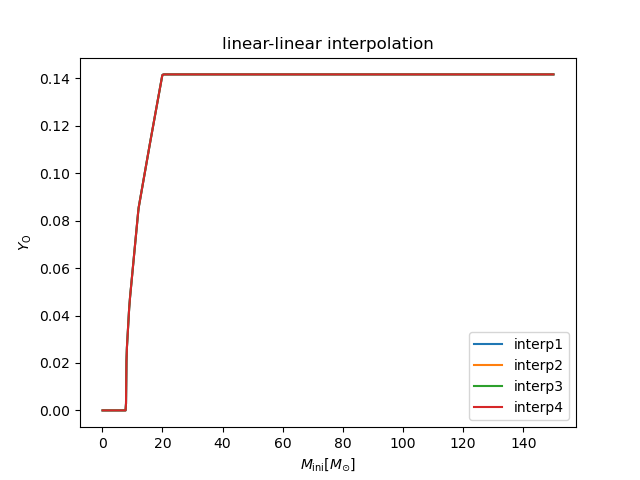

nan
nan
0.0
{'SNIa': {}, 'AGB+SNcc': {'low': 0, 'high': 0}}


In [11]:
# Test 'AGB+SNcc' and 'linear-linear' interpolation
elem = 'C'
StarType = 'AGB+SNcc'
Z_gas = 1e-4
interp1 = interpolate_yield_Z(Z_gas, StarType, 'C', kind='linear-linear')
x_low = dfs[StarType][groups[StarType][Zindex[StarType]['low']]].columns.to_numpy().astype(np.float64)
x_high = dfs[StarType][groups[StarType][Zindex[StarType]['high']]].columns.to_numpy().astype(np.float64)
y_low = dfs[StarType][groups[StarType][Zindex[StarType]['low']]].loc[elem].to_numpy().astype(np.float64)
y_high = dfs[StarType][groups[StarType][Zindex[StarType]['high']]].loc[elem].to_numpy().astype(np.float64)
interp_low = interpolate.interp1d(x_low, y_low, kind='linear', fill_value='extrapolate')
interp_high = interpolate.interp1d(x_high, y_high, kind='linear', fill_value='extrapolate')

Z_low = Zyield[StarType][Zindex[StarType]['low']]
Z_high = Zyield[StarType][Zindex[StarType]['high']]

interp2 = lambda x: interp_low(x) + (interp_high(x)-interp_low(x))/(Z_high-Z_low)*(Z_gas-Z_low)
interp_Y = InterpolateYields(dfs, kind='linear-linear')
interp3 = interp_Y.interpolate_Z_AGB_SNcc(Z_gas, elem)
interp4 = interp_Y.interps['AGB+SNcc'](Z_gas, elem)
m = np.linspace(0.08, 150, 1000)
fig, ax = plt.subplots()
ax.plot(m, interp1(m), label='interp1')
ax.plot(m, interp2(m), label='interp2')
ax.plot(m, interp3(m), label='interp3')
ax.plot(m, interp4(m), label='interp4')
ax.set_xlabel(r'$M_{\rm ini}[M_{\odot}]$')
ax.set_ylabel(r'$Y_{\rm O}$')
ax.set_title("linear-linear interpolation")
ax.legend()
plt.show()
print(np.abs(interp1(m)-interp2(m)).max())
print(np.abs(interp2(m)-interp3(m)).max())
print(np.abs(interp3(m)-interp4(m)).max())
print(interp_Y.Zindex)

In [22]:
a = 7.899
b = 8
c = 9.3
epsrel = 1e-8
ans1 = quad(lambda m: m**(-2.35)*interp1(m), a, c, epsrel=epsrel, limit=80, full_output=1)
ans2 = quad(lambda m: m**(-2.35)*interp1(m), a, b, epsrel=epsrel, limit=80, full_output=1)
ans3 = quad(lambda m: m**(-2.35)*interp1(m), b, c, epsrel=epsrel, limit=80, full_output=1)
print((ans1[0] - ans2[0] - ans3[0])/ans1[0], (ans1[0] - ans2[0] - ans3[0]), ans1[0])

-2.7159938114237664e-06 -8.180065825548997e-10 0.0003011813131216554


In [17]:
interp1(8)

array(0.01671734)

In [8]:
Zyield

{'AGB+SNcc': array([0.0004, 0.004 , 0.008 , 0.0127]), 'SNIa': array([0.02])}

In [ ]:
import time
def func1(a, b):
    time.sleep(2e-4)
    if a > b:
        def func(x):
            return x**(-2.35)
        return func
    else:
        def func(x):
            return x**(-3.35)
        return func

        


func2 = func1(2, -1.4)
xlow = 0.08
xhigh = 150
func3 = lambda x, a, b: func1(a, b)(x)/x
for i in tqdm(range(100)):
    quad(lambda x: 1/x*func1(2, -1.4)(x), xlow, xhigh, epsrel=1e-5, limit=80, full_output=1)

for i in tqdm(range(100)):
    quad(lambda x: 1/x*func2(x), xlow, xhigh, epsrel=1e-5, limit=80, full_output=1)

for i in tqdm(range(100)):
    quad(func3, xlow, xhigh, args=(2, -1.4), epsrel=1e-5, limit=80, full_output=1)

100%|██████████| 100/100 [00:10<00:00,  9.61it/s]


In [ ]:
func1(2, -1.4)

<function __main__.func1.<locals>.<lambda>(x)>

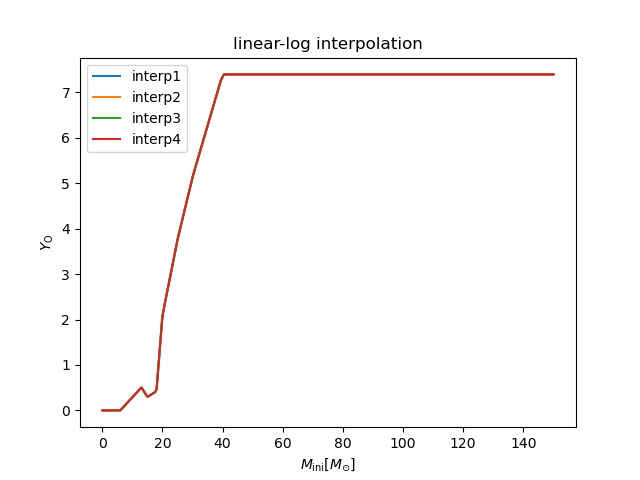

0.0
0.0
0.0
{'SNIa': {}, 'AGB+SNcc': {'high': 1, 'low': 0}}


In [ ]:
# Test 'AGB+SNcc' and 'linear-log' interpolation
StarType = 'AGB+SNcc'
Z_gas = 0.0002
interp1 = interpolate_yield_Z(Z_gas, StarType, 'O', kind='linear-log')
x_low = dfs[StarType][groups[StarType][Zindex[StarType]['low']]].columns.to_numpy().astype(np.float64)
x_high = dfs[StarType][groups[StarType][Zindex[StarType]['high']]].columns.to_numpy().astype(np.float64)
y_low = dfs[StarType][groups[StarType][Zindex[StarType]['low']]].loc['O'].to_numpy().astype(np.float64)
y_high = dfs[StarType][groups[StarType][Zindex[StarType]['high']]].loc['O'].to_numpy().astype(np.float64)
interp_low = interpolate.interp1d(x_low, y_low, kind='linear', fill_value='extrapolate')
interp_high = interpolate.interp1d(x_high, y_high, kind='linear', fill_value='extrapolate')

Z_low = Zyield[StarType][Zindex[StarType]['low']]
Z_high = Zyield[StarType][Zindex[StarType]['high']]

interp2 = lambda x: interp_low(x) + (interp_high(x)-interp_low(x))/\
                        (np.log10(Z_high)-np.log10(Z_low))*(np.log10(Z_gas)-np.log10(Z_low))
interp_Y = InterpolateYields(dfs, kind='linear-log')
interp3 = interp_Y.interpolate_Z_AGB_SNcc(Z_gas, 'O')
interp4 = interp_Y.interps['AGB+SNcc'](Z_gas, 'O')
m = np.linspace(0.08, 150, 1000)
fig, ax = plt.subplots()
ax.plot(m, interp1(m), label='interp1')
ax.plot(m, interp2(m), label='interp2')
ax.plot(m, interp3(m), label='interp3')
ax.plot(m, interp4(m), label='interp4')
ax.set_xlabel(r'$M_{\rm ini}[M_{\odot}]$')
ax.set_ylabel(r'$Y_{\rm O}$')
ax.set_title("linear-log interpolation")
ax.legend()
plt.show()
print(np.abs(interp1(m)-interp2(m)).max())
print(np.abs(interp2(m)-interp3(m)).max())
print(np.abs(interp3(m)-interp4(m)).max())
print(interp_Y.Zindex)

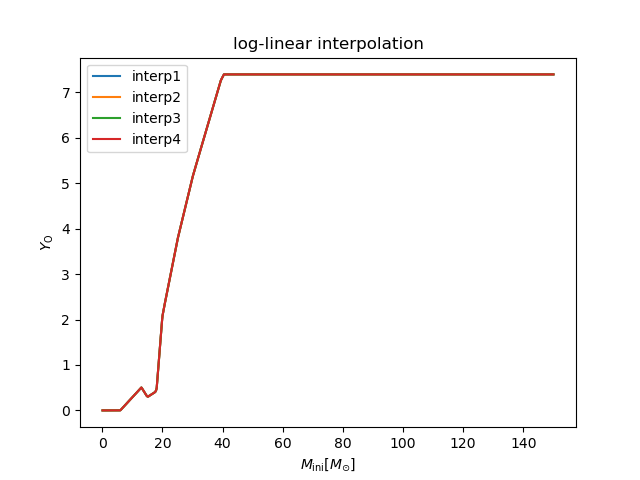

0.0
0.0
0.0
{'SNIa': {}, 'AGB+SNcc': {'high': 1, 'low': 0}}


In [ ]:
# Test 'AGB+SNcc' and 'log-linear' interpolation
StarType = 'AGB+SNcc'
Z_gas = 0.0002
interp1 = interpolate_yield_Z(Z_gas, StarType, 'O', kind='log-linear')
x_low = dfs[StarType][groups[StarType][Zindex[StarType]['low']]].columns.to_numpy().astype(np.float64)
x_high = dfs[StarType][groups[StarType][Zindex[StarType]['high']]].columns.to_numpy().astype(np.float64)
y_low = dfs[StarType][groups[StarType][Zindex[StarType]['low']]].loc['O'].to_numpy().astype(np.float64)
y_high = dfs[StarType][groups[StarType][Zindex[StarType]['high']]].loc['O'].to_numpy().astype(np.float64)
interp_low = interpolate.interp1d(x_low, y_low, kind='linear', fill_value='extrapolate')
interp_high = interpolate.interp1d(x_high, y_high, kind='linear', fill_value='extrapolate')

Z_low = Zyield[StarType][Zindex[StarType]['low']]
Z_high = Zyield[StarType][Zindex[StarType]['high']]


interp2 = lambda x: interp_low(x) ** ((Z_high-Z_gas)/(Z_high-Z_low)) * \
                        interp_high(x) ** ((Z_gas-Z_low)/(Z_high-Z_low))
interp_Y = InterpolateYields(dfs, kind='log-linear')
interp3 = interp_Y.interpolate_Z_AGB_SNcc(Z_gas, 'O')
interp4 = interp_Y.interps['AGB+SNcc'](Z_gas, 'O')
m = np.linspace(0.08, 150, 1000)
fig, ax = plt.subplots()
ax.plot(m, interp1(m), label='interp1')
ax.plot(m, interp2(m), label='interp2')
ax.plot(m, interp3(m), label='interp3')
ax.plot(m, interp4(m), label='interp4')
ax.set_xlabel(r'$M_{\rm ini}[M_{\odot}]$')
ax.set_ylabel(r'$Y_{\rm O}$')
ax.set_title("log-linear interpolation")
ax.legend()
plt.show()
print(np.abs(interp1(m)-interp2(m)).max())
print(np.abs(interp2(m)-interp3(m)).max())
print(np.abs(interp3(m)-interp4(m)).max())
print(interp_Y.Zindex)

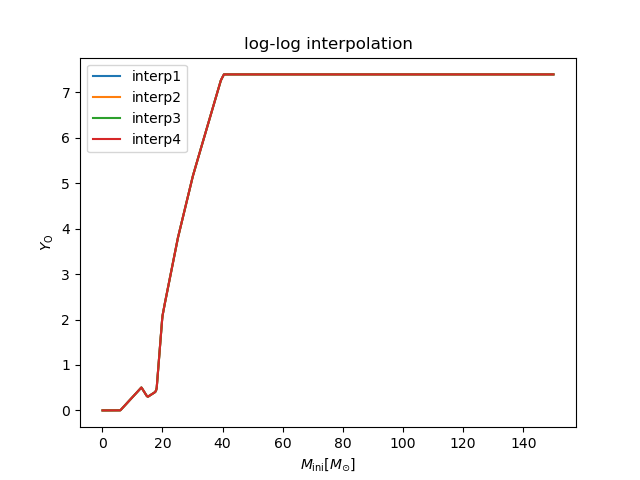

0.0
0.0
0.0
{'SNIa': {}, 'AGB+SNcc': {'high': 1, 'low': 0}}


In [ ]:
# Test 'AGB+SNcc' and 'log-log' interpolation
StarType = 'AGB+SNcc'
Z_gas = 0.0002
interp1 = interpolate_yield_Z(Z_gas, StarType, 'O', kind='log-log')
x_low = dfs[StarType][groups[StarType][Zindex[StarType]['low']]].columns.to_numpy().astype(np.float64)
x_high = dfs[StarType][groups[StarType][Zindex[StarType]['high']]].columns.to_numpy().astype(np.float64)
y_low = dfs[StarType][groups[StarType][Zindex[StarType]['low']]].loc['O'].to_numpy().astype(np.float64)
y_high = dfs[StarType][groups[StarType][Zindex[StarType]['high']]].loc['O'].to_numpy().astype(np.float64)
interp_low = interpolate.interp1d(x_low, y_low, kind='linear', fill_value='extrapolate')
interp_high = interpolate.interp1d(x_high, y_high, kind='linear', fill_value='extrapolate')

Z_low = Zyield[StarType][Zindex[StarType]['low']]
Z_high = Zyield[StarType][Zindex[StarType]['high']]


interp2 = lambda x: interp_low(x) ** ((np.log10(Z_high)-np.log10(Z_gas))/(np.log10(Z_high)-np.log10(Z_low))) * \
                        interp_high(x) ** ((np.log10(Z_gas)-np.log10(Z_low))/(np.log10(Z_high)-np.log10(Z_low)))
interp_Y = InterpolateYields(dfs, kind='log-log')
interp3 = interp_Y.interpolate_Z_AGB_SNcc(Z_gas, 'O')
interp4 = interp_Y.interps['AGB+SNcc'](Z_gas, 'O')
m = np.linspace(0.08, 150, 1000)
fig, ax = plt.subplots()
ax.plot(m, interp1(m), label='interp1')
ax.plot(m, interp2(m), label='interp2')
ax.plot(m, interp3(m), label='interp3')
ax.plot(m, interp4(m), label='interp4')
ax.set_xlabel(r'$M_{\rm ini}[M_{\odot}]$')
ax.set_ylabel(r'$Y_{\rm O}$')
ax.set_title("log-log interpolation")
ax.legend()
plt.show()
print(np.abs(interp1(m)-interp2(m)).max())
print(np.abs(interp2(m)-interp3(m)).max())
print(np.abs(interp3(m)-interp4(m)).max())
print(interp_Y.Zindex)

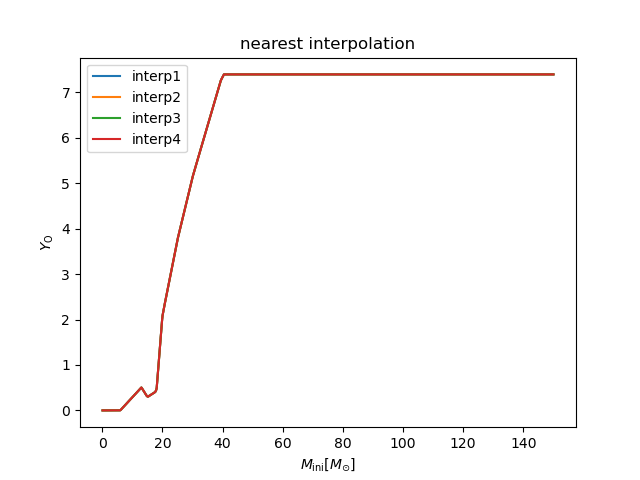

0.0
0.0
0.0
{'SNIa': {}, 'AGB+SNcc': {'low': 1, 'high': 1}}


In [ ]:
# Test 'AGB+SNcc' and 'nearest' interpolation
StarType = 'AGB+SNcc'
Z_gas = 0.0002
interp1 = interpolate_yield_Z(Z_gas, StarType, 'O', kind='nearest')
x_low = dfs[StarType][groups[StarType][Zindex[StarType]['low']]].columns.to_numpy().astype(np.float64)
x_high = dfs[StarType][groups[StarType][Zindex[StarType]['high']]].columns.to_numpy().astype(np.float64)
y_low = dfs[StarType][groups[StarType][Zindex[StarType]['low']]].loc['O'].to_numpy().astype(np.float64)
y_high = dfs[StarType][groups[StarType][Zindex[StarType]['high']]].loc['O'].to_numpy().astype(np.float64)
interp_low = interpolate.interp1d(x_low, y_low, kind='linear', fill_value='extrapolate')
interp_high = interpolate.interp1d(x_high, y_high, kind='linear', fill_value='extrapolate')

Z_low = Zyield[StarType][Zindex[StarType]['low']]
Z_high = Zyield[StarType][Zindex[StarType]['high']]


interp2 = lambda x: interp_low(x)
interp_Y = InterpolateYields(dfs, kind='nearest')
interp3 = interp_Y.interpolate_Z_AGB_SNcc(Z_gas, 'O')
interp4 = interp_Y.interps['AGB+SNcc'](Z_gas, 'O')
m = np.linspace(0.08, 150, 1000)
fig, ax = plt.subplots()
ax.plot(m, interp1(m), label='interp1')
ax.plot(m, interp2(m), label='interp2')
ax.plot(m, interp3(m), label='interp3')
ax.plot(m, interp4(m), label='interp4')
ax.set_xlabel(r'$M_{\rm ini}[M_{\odot}]$')
ax.set_ylabel(r'$Y_{\rm O}$')
ax.set_title("nearest interpolation")
ax.legend()
plt.show()
print(np.abs(interp1(m)-interp2(m)).max())
print(np.abs(interp2(m)-interp3(m)).max())
print(np.abs(interp3(m)-interp4(m)).max())
print(interp_Y.Zindex)

In [ ]:
# Test 'SNIa' and 'linear-linear' interpolation
StarType = 'SNIa'
Z_gas = 0.015
y1 = interpolate_yield_Z(Z_gas, StarType, 'O', kind='linear-linear')
y_low = dfs[StarType][groups[StarType][Zindex[StarType]['low']]].loc['O'].to_numpy().astype(np.float64)
y_high = dfs[StarType][groups[StarType][Zindex[StarType]['high']]].loc['O'].to_numpy().astype(np.float64)
Z_low = Zyield[StarType][Zindex[StarType]['low']]
Z_high = Zyield[StarType][Zindex[StarType]['high']]
y2 = y_low + (y_high-y_low)/(Z_high-Z_low)*(Z_gas-Z_low)
print("linear-linear interpolation")
interp_Y = InterpolateYields(dfs, kind='linear-linear')
y3 = interp_Y.interpolate_Z_SNIa(Z_gas, 'O')
y4 = interp_Y.interps['SNIa'](Z_gas, 'O')
print(y1-y2)
print(y3-y2)
print(y4-y3)
print(interp_Y.Zindex)

linear-linear interpolation
[0.]
[0.]
0.0
{'SNIa': {'high': 3, 'low': 2}, 'AGB+SNcc': {}}


In [ ]:
# Test 'SNIa' and 'linear-log' interpolation
StarType = 'SNIa'
Z_gas = 0.015
y1 = interpolate_yield_Z(Z_gas, StarType, 'O', kind='linear-log')
y_low = dfs[StarType][groups[StarType][Zindex[StarType]['low']]].loc['O'].to_numpy().astype(np.float64)
y_high = dfs[StarType][groups[StarType][Zindex[StarType]['high']]].loc['O'].to_numpy().astype(np.float64)

Z_low = Zyield[StarType][Zindex[StarType]['low']]
Z_high = Zyield[StarType][Zindex[StarType]['high']]
y2 = y_low + (y_high-y_low)/(np.log10(Z_high)-np.log10(Z_low))*(np.log10(Z_gas)-np.log10(Z_low))
y3 = y_low + (y_high-y_low)/(np.log10(Z_high)-np.log10(Z_low))*(np.log10(Z_gas)-np.log10(Z_low))
print("linear-log interpolation")
interp_Y = InterpolateYields(dfs, kind='linear-log')
y3 = interp_Y.interpolate_Z_SNIa(Z_gas, 'O')
y4 = interp_Y.interps['SNIa'](Z_gas, 'O')
print(y1-y2)
print(y3-y2)
print(y4-y3)
print(interp_Y.Zindex)

linear-log interpolation
[0.]
[0.]
0.0
{'SNIa': {'high': 3, 'low': 2}, 'AGB+SNcc': {}}


In [ ]:
# Test 'SNIa' and 'log-linear' interpolation
StarType = 'SNIa'
Z_gas = 0.015
y1 = interpolate_yield_Z(Z_gas, StarType, 'O', kind='log-linear')
y_low = dfs[StarType][groups[StarType][Zindex[StarType]['low']]].loc['O'].to_numpy().astype(np.float64)
y_high = dfs[StarType][groups[StarType][Zindex[StarType]['high']]].loc['O'].to_numpy().astype(np.float64)

Z_low = Zyield[StarType][Zindex[StarType]['low']]
Z_high = Zyield[StarType][Zindex[StarType]['high']]
y2 = y_low ** ((Z_high-Z_gas)/(Z_high-Z_low)) * y_high ** ((Z_gas-Z_low)/(Z_high-Z_low))
print("log-linear interpolation")
interp_Y = InterpolateYields(dfs, kind='log-linear')
y3 = interp_Y.interpolate_Z_SNIa(Z_gas, 'O')
y4 = interp_Y.interps['SNIa'](Z_gas, 'O')
print(y1-y2)
print(y3-y2)
print(y4-y3)
print(interp_Y.Zindex)

log-linear interpolation
[0.]
[0.]
0.0
{'SNIa': {'high': 3, 'low': 2}, 'AGB+SNcc': {}}


In [ ]:
# Test 'SNIa' and 'log-log' interpolation
StarType = 'SNIa'
Z_gas = 0.015
y1 = interpolate_yield_Z(Z_gas, StarType, 'O', kind='log-log')
y_low = dfs[StarType][groups[StarType][Zindex[StarType]['low']]].loc['O'].to_numpy().astype(np.float64)
y_high = dfs[StarType][groups[StarType][Zindex[StarType]['high']]].loc['O'].to_numpy().astype(np.float64)

Z_low = Zyield[StarType][Zindex[StarType]['low']]
Z_high = Zyield[StarType][Zindex[StarType]['high']]
y2 = y_low ** ((np.log10(Z_high)-np.log10(Z_gas))/(np.log10(Z_high)-np.log10(Z_low))) \
    * y_high ** ((np.log10(Z_gas)-np.log10(Z_low))/(np.log10(Z_high)-np.log10(Z_low)))
print("log-log interpolation")
interp_Y = InterpolateYields(dfs, kind='log-log')
y3 = interp_Y.interpolate_Z_SNIa(Z_gas, 'O')
y4 = interp_Y.interps['SNIa'](Z_gas, 'O')
print(y1-y2)
print(y3-y2)
print(y4-y3)
print(interp_Y.Zindex)

log-log interpolation
[0.]
[0.]
0.0
{'SNIa': {'high': 3, 'low': 2}, 'AGB+SNcc': {}}


In [ ]:
# Test 'SNIa' and 'log-log' interpolation
StarType = 'SNIa'
Z_gas = 0.015
y1 = interpolate_yield_Z(Z_gas, StarType, 'O', kind='nearest')
y_low = dfs[StarType][groups[StarType][Zindex[StarType]['low']]].loc['O'].to_numpy().astype(np.float64)
y_high = dfs[StarType][groups[StarType][Zindex[StarType]['high']]].loc['O'].to_numpy().astype(np.float64)

Z_low = Zyield[StarType][Zindex[StarType]['low']]
Z_high = Zyield[StarType][Zindex[StarType]['high']]
y2 = y_low
print("nearest interpolation")
interp_Y = InterpolateYields(dfs, kind='nearest')
y3 = interp_Y.interpolate_Z_SNIa(Z_gas, 'O')
y4 = interp_Y.interps['SNIa'](Z_gas, 'O')
print(y1-y2)
print(y3-y2)
print(y4-y3)
print(interp_Y.Zindex)

nearest interpolation
[0.]
[0.]
0.0
{'SNIa': {'low': 2, 'high': 2}, 'AGB+SNcc': {}}


In [ ]:
interp_Y.interps['SNIa']

<function __main__.InterpolateYields.__init__.<locals>.<lambda>(ZGas, elem)>